In [1]:
import cryptocompare_fede
from datetime import datetime

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
data = []
assets = ["NEXO", "SALT", "LEND", "PPT", "BLT"]
for asset in assets:
    print("Downloading "+asset+"...")
    new_data = cryptocompare_fede.get_historical_price_day(asset, 'USD', 1000)
    new_data_table = pd.DataFrame(data = new_data["Data"])
    new_data_table = new_data_table.rename(index=str, columns={"time":"Date"})
    new_data_table = new_data_table.rename(index=str, columns={"close":asset})
    new_data_table.index = pd.to_datetime(new_data_table["Date"],  unit='s')
    data.append(new_data_table[asset])
num_assets = len(assets) 
table = pd.concat([idata for idata in data], axis=1)

In [4]:
table = table.dropna()
table = table[(table.T > 0).all()]
table.head()

,NEXO,SALT,LEND,PPT,BLT
Date,,,,,
2018-06-04,0.1928,1.95,0.04539,12.16,0.4347
2018-06-05,0.1869,2.00,0.04562,12.28,0.4181
2018-06-06,0.1785,1.95,0.04421,11.98,0.4176
2018-06-07,0.1717,1.94,0.04351,11.07,0.3899
2018-06-08,0.1693,1.85,0.04447,11.22,0.3923


/home/fedecaccia/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'price in $')

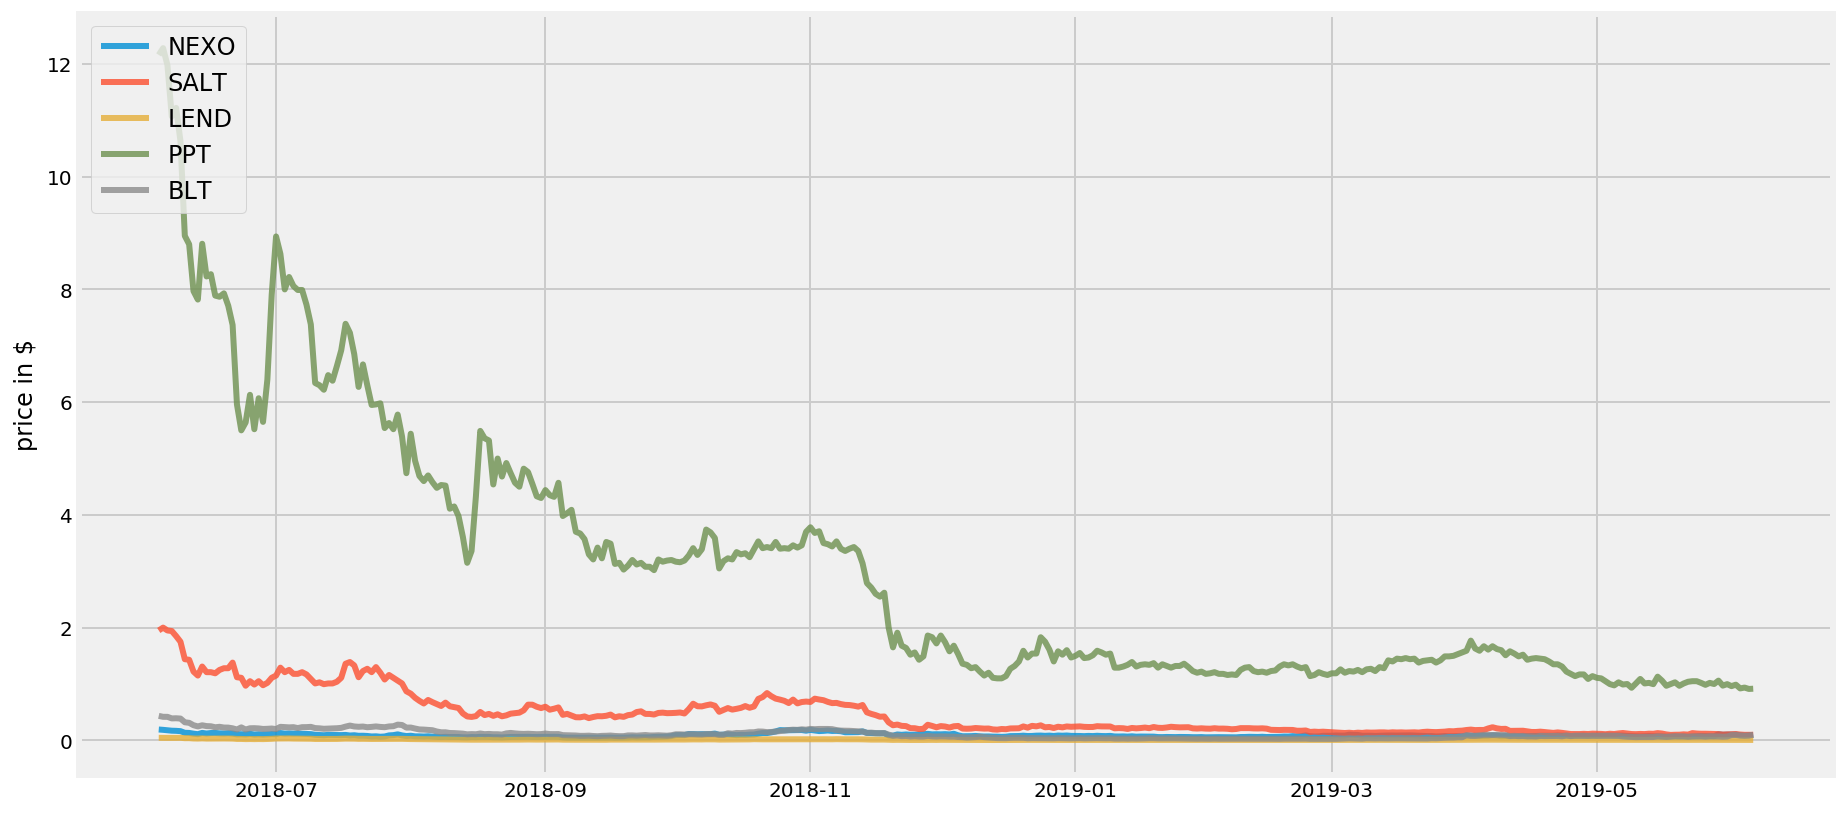

In [5]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'daily returns')

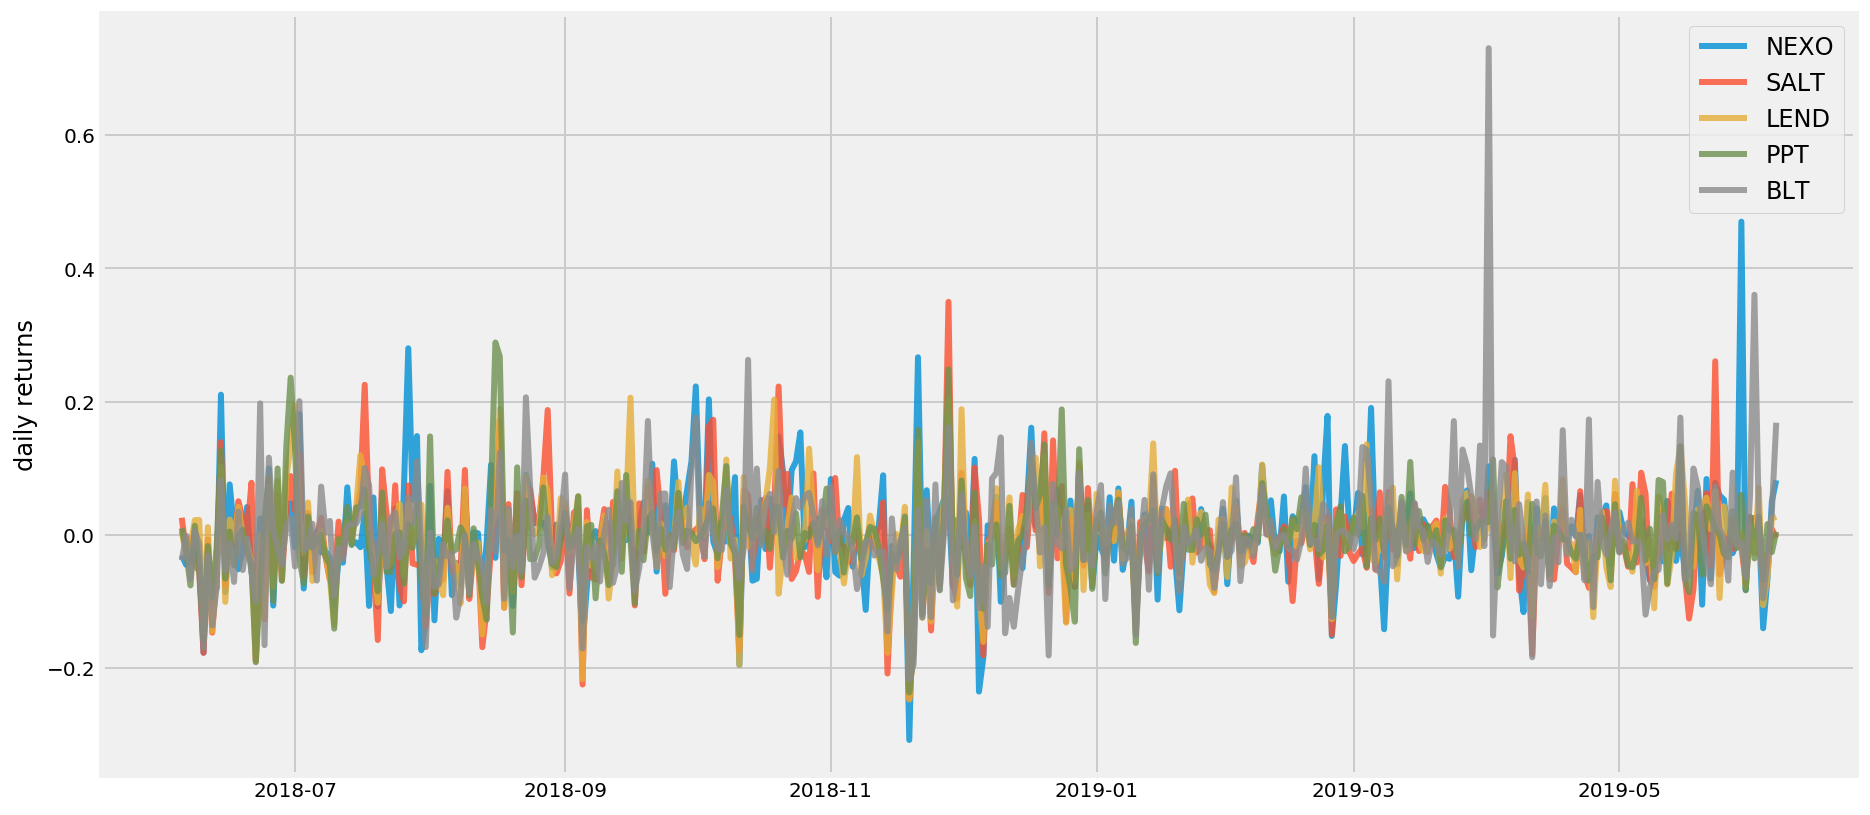

In [6]:
returns = table.pct_change()
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [7]:
trading_days_per_year = 365

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *trading_days_per_year
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(trading_days_per_year)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [8]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 50000
risk_free_rate = 0.0178

In [9]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualized Return:", round(rp,2))
    print ("Annualized Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualized Return:", round(rp_min,2))
    print ("Annualized Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    
    print ("-"*80)
    an_vol = np.std(returns) * np.sqrt(trading_days_per_year)
    an_rt = mean_returns * trading_days_per_year
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print (txt,":","Annualized return",round(an_rt[i],2),", Annualized volatility:",round(an_vol[i],2))
    print ("-"*80) 
       
    
    plt.figure(figsize=(13, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualized Votility')
    plt.ylabel('Annualized Returns')
    plt.legend(labelspacing=0.8)
    
    
    #fig, ax = plt.subplots(figsize=(10, 7))
    plt.scatter(an_vol,an_rt,marker='o',s=200)
    for i, txt in enumerate(table.columns):
        plt.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 0.11
Annualized Volatility: 1.29


             NEXO  SALT  LEND   PPT    BLT
allocation  78.44   0.3  2.82  3.01  15.43
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualized Return: -1.09
Annualized Volatility: 1.05


             NEXO   SALT   LEND   PPT    BLT
allocation  17.92  10.16  16.01  41.0  14.91
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

NEXO : Annualized return 0.31 , Annualized volatility: 1.43
SALT : Annualized return -2.02 , Annualized volatility: 1.36
LEND : Annualized return -0.85 , Annualized volatility: 1.28
PPT : Annualized return -1.86 , Annualized volatility: 1.19
BLT : Annualized return -0.29 , Annualized volatility: 1.59
---------------------------------------------

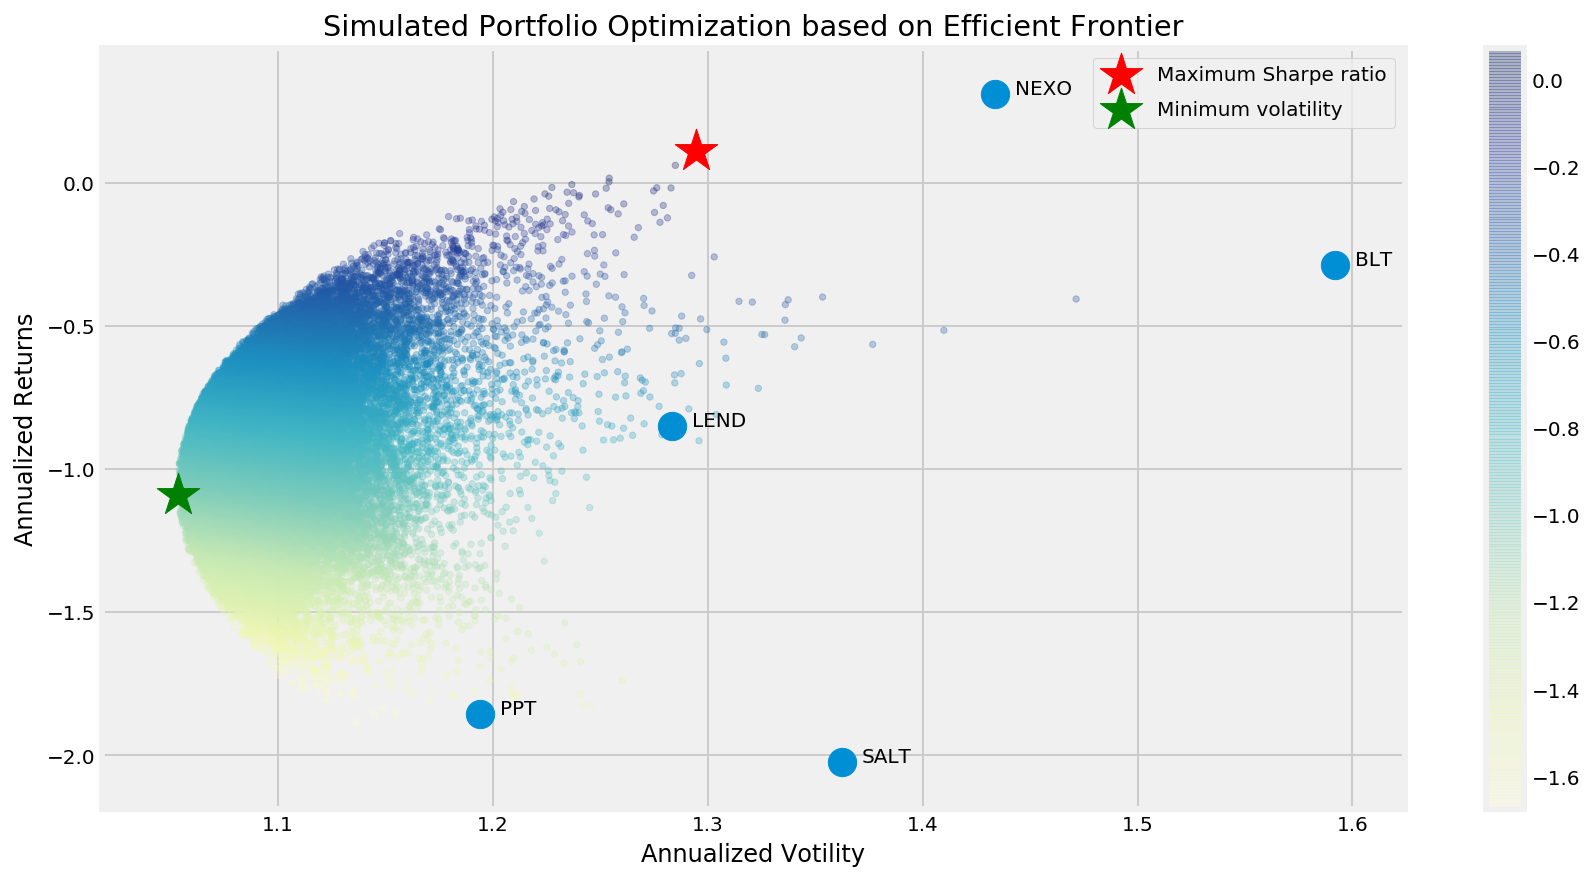

In [10]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)